<a href="https://colab.research.google.com/github/abduallheid/tomato_leaves/blob/main/tomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 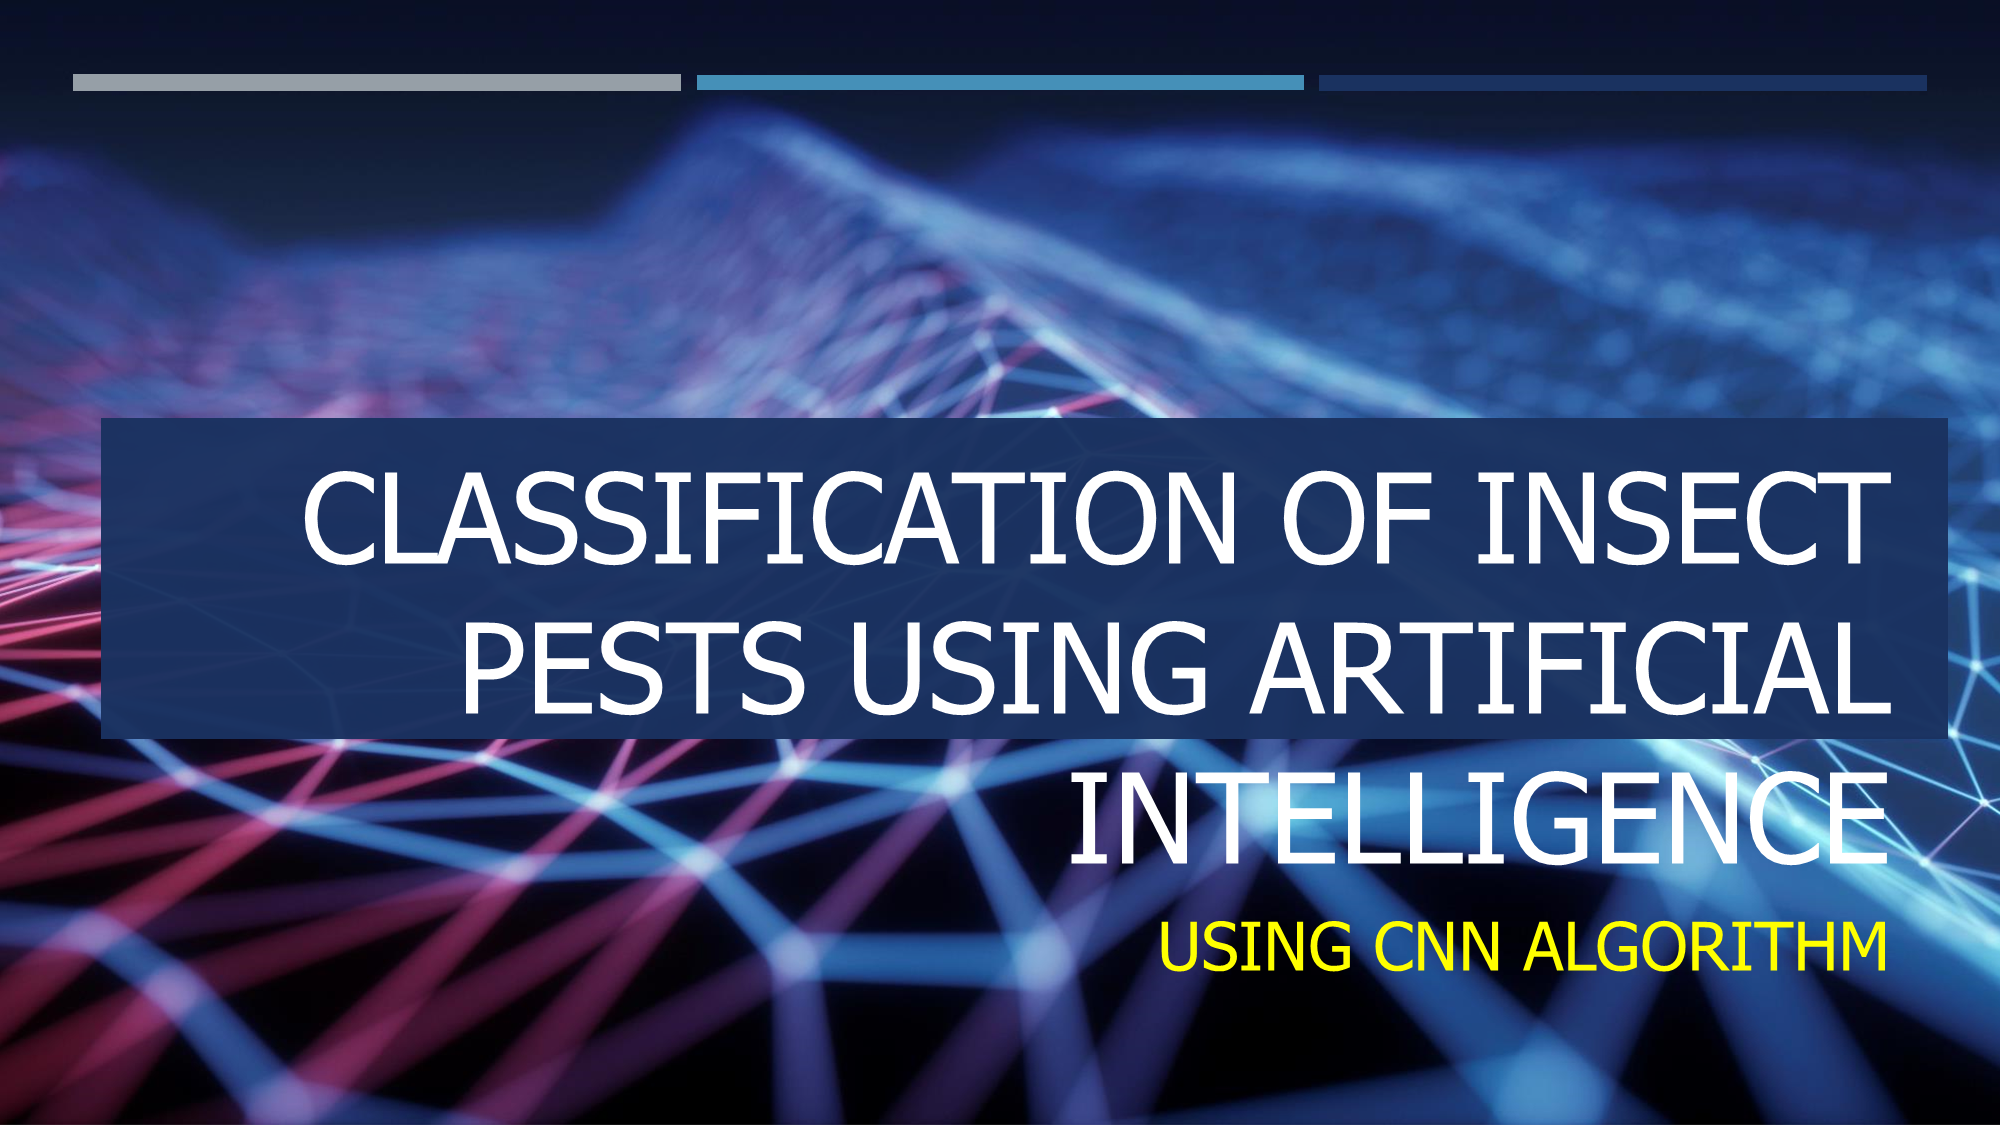

# CNN-MULTI-CLASSIFICATION-IMAGE


# TEAM

### عبدالله عيد رواق (8351)

### احمد حسن اسماعيل (8305)
### محمود مجدى كامل (8388)
### مصطفى اشرف رجائى (7262)
###  محمد حافظ عمر (6322)
### احمد بدوى سيد (8302)
### محمد محمود على (8431)
### محمد فؤاد حسن(8376)
### ابراهيم الحسينى جاد الكريم (8298)
### سيد سعيد سيد(8340)

### (احمد  عيد على (8427


### Data source:
https://www.ipmimages.org/browse/Areathumb.cfm?area=72


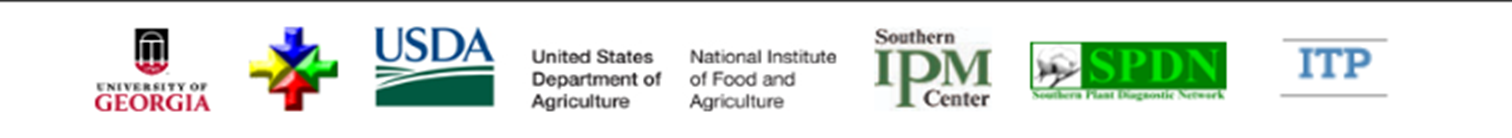

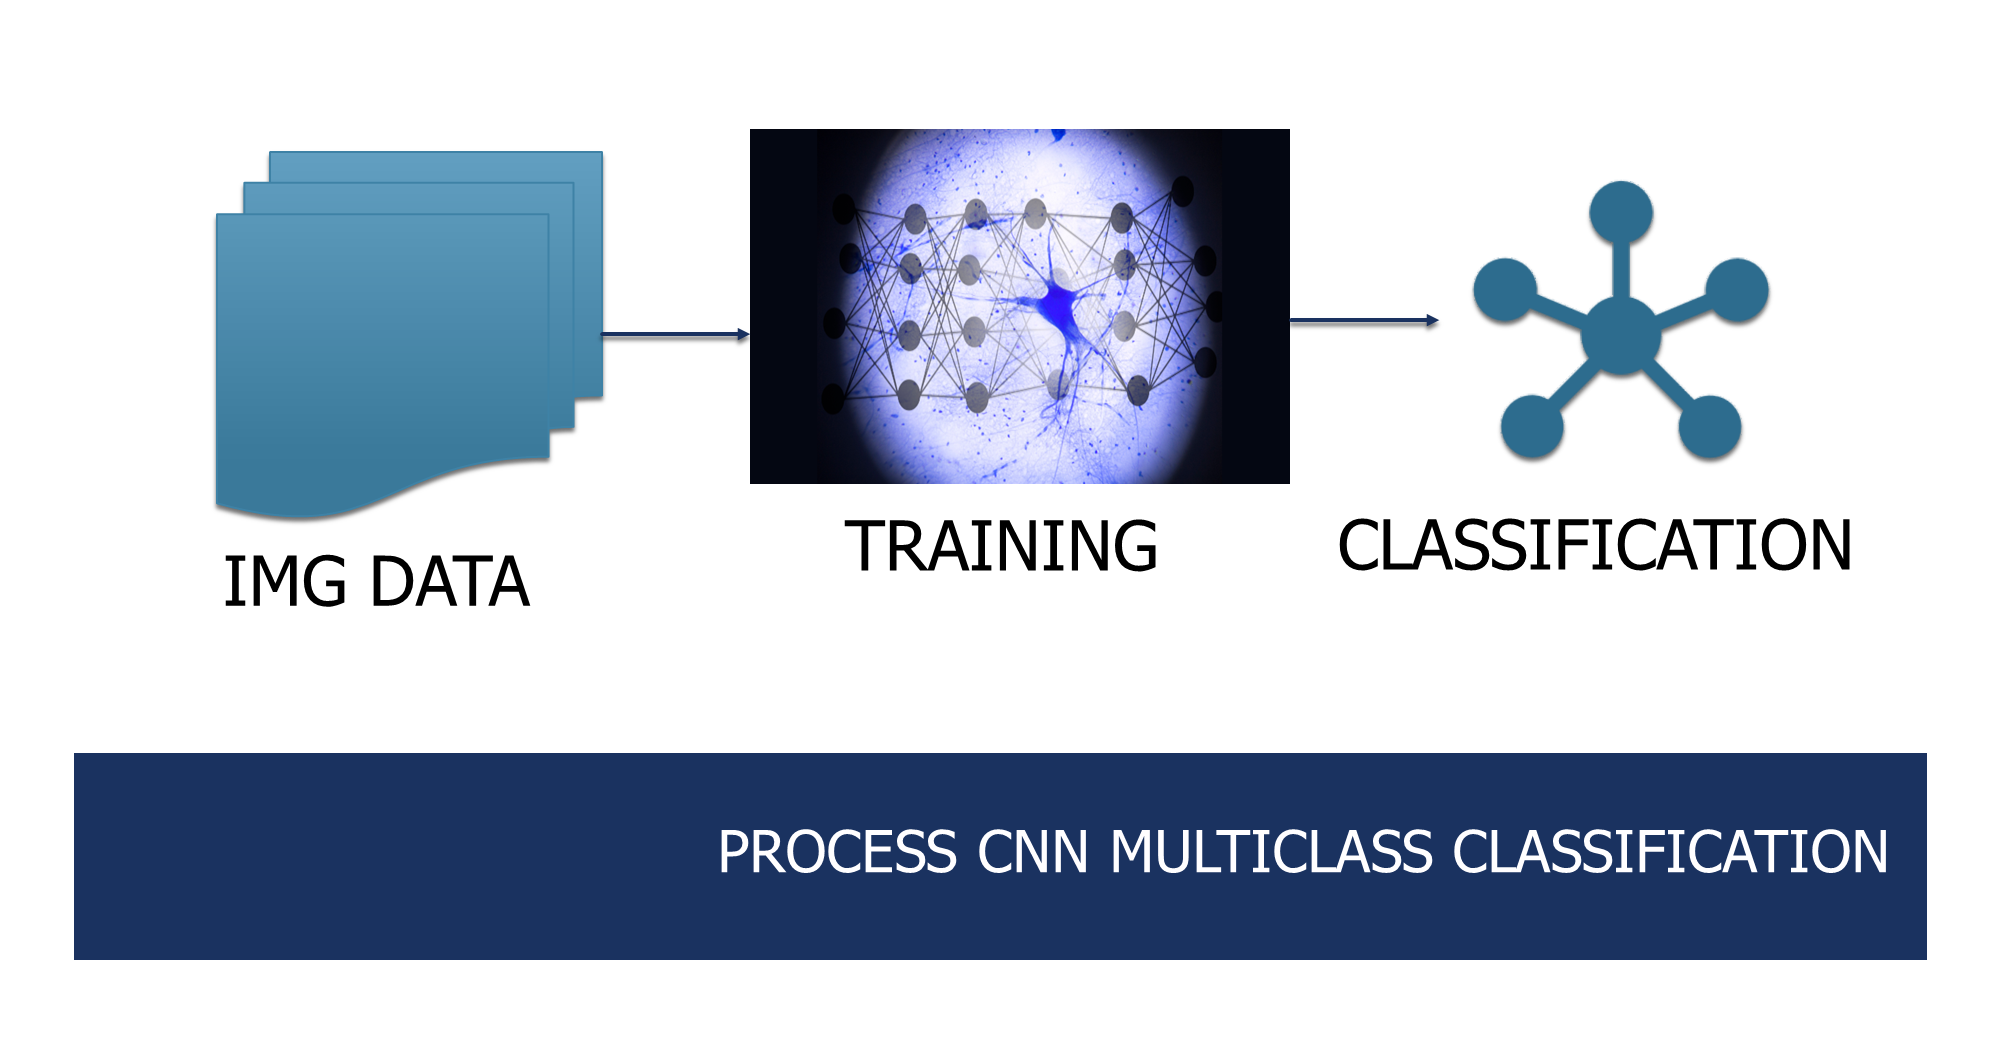

## 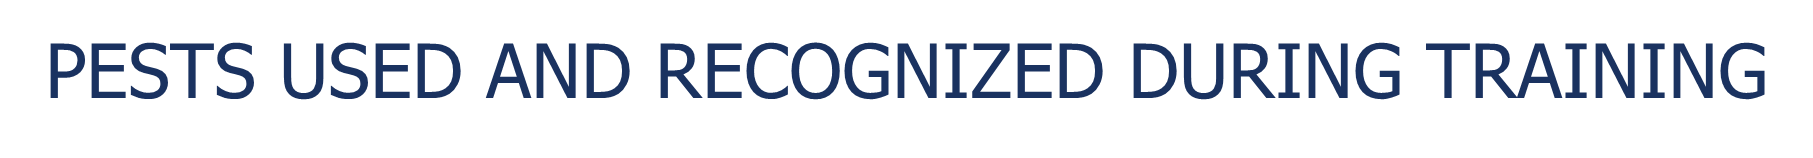



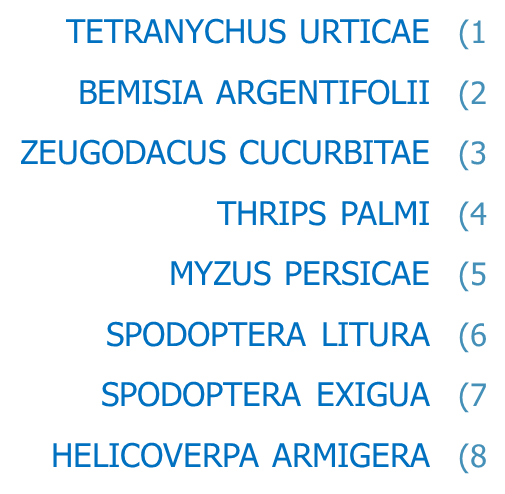


# UPLOAD DATASET & UNRAR 

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unrar x "/content/drive/MyDrive/tomato.rar" "/content/drive/MyDrive/output_folder/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/tomato.rar

Creating    /content/drive/MyDrive/output_folder                      OK
Creating    /content/drive/MyDrive/output_folder/tomato               OK
Creating    /content/drive/MyDrive/output_folder/tomato/BA            OK
Extracting  /content/drive/MyDrive/output_folder/tomato/BA/BA (1).jpg       0%  OK 
Extracting  /content/drive/MyDrive/output_folder/tomato/BA/BA (10).jpg       0%  OK 
Extracting  /content/drive/MyDrive/output_folder/tomato/BA/BA (11).jpg       0%  OK 
Extracting  /content/drive/MyDrive/output_folder/tomato/BA/BA (12).jpg       0%  OK 
Extracting  /content/drive/MyDrive/output_folder/tomato/BA/BA (13).jpg       0%  OK 
Extracting  /content/drive/MyDrive/output_folder/tomato/BA/BA (14).jpg       0%  OK 
Extracting  /content/drive/MyDrive/output_folder/tomato/BA/BA (15).jpg       0%  OK 
Extr

# IMPORT NESSARY LIBARARY & MODELS

In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# STANDRIZED FEATURES

In [27]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [28]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/output_folder/tomato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4263 files belonging to 8 classes.


In [29]:
class_names = dataset.class_names
class_names

['BA', 'HA', 'MP', 'SE', 'SL', 'TP', 'TU', 'ZC']

In [30]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 3 2 2 1 4 2 6 2 3 1 4 4 5 4 2 2 6 1 1 2 2 3 0 4 4 3 3 1 7 2 3]


# Visualize some of TRAIN images from our dataset

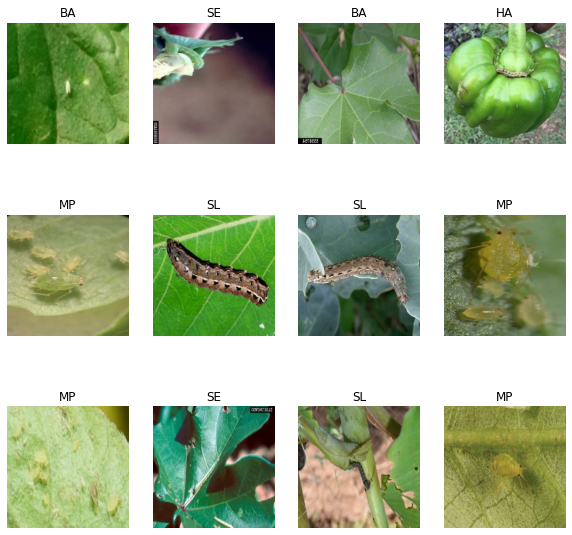

In [31]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

 # Split Dataset


### Training ▶ Dataset to be used while training

### Validation ▶ Dataset to be tested against while training

### Test▶ Dataset to be tested against after we trained a model

In [32]:
len(dataset)

134

In [33]:
train_size = 0.8
len(dataset)*train_size

107.2

In [34]:
train_ds = dataset.take(107)
len(train_ds)

107

In [35]:
test_ds = dataset.skip(107)
len(test_ds)

27

In [36]:
val_size=0.1
len(dataset)*val_size
val_ds = test_ds.take(6)
len(val_ds)
test_ds = test_ds.skip(6)
len(test_ds)

21

In [37]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [39]:
len(train_ds)


107

## Cache, Shuffle, and Prefetch the Dataset

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
Creating a Layer for Resizing and Normalization

In [41]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation


In [42]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [43]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [44]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [45]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
107/107 [==============================] - 60s 444ms/step - loss: 2.0008 - accuracy: 0.1962 - val_loss: 1.9672 - val_accuracy: 0.1971
Epoch 2/50
107/107 [==============================] - 35s 326ms/step - loss: 1.8622 - accuracy: 0.2795 - val_loss: 1.7651 - val_accuracy: 0.2861
Epoch 3/50
107/107 [==============================] - 35s 322ms/step - loss: 1.7019 - accuracy: 0.3689 - val_loss: 1.6021 - val_accuracy: 0.4087
Epoch 4/50
107/107 [==============================] - 37s 341ms/step - loss: 1.5488 - accuracy: 0.4378 - val_loss: 1.4749 - val_accuracy: 0.4423
Epoch 5/50
107/107 [==============================] - 36s 338ms/step - loss: 1.4933 - accuracy: 0.4469 - val_loss: 1.4856 - val_accuracy: 0.4447
Epoch 6/50
107/107 [==============================] - 36s 332ms/step - loss: 1.4161 - accuracy: 0.4772 - val_loss: 1.3216 - val_accuracy: 0.4976
Epoch 7/50
107/107 [==============================] - 36s 332ms/step - loss: 1.3231 - accuracy: 0.5104 - val_loss: 1.3882 - val_ac

In [48]:
scores = model.evaluate(test_ds)


14/14 [==============================] - 15s 58ms/step - loss: 0.1292 - accuracy: 0.9509


In [49]:
scores

[0.12924043834209442, 0.9508928656578064]

In [51]:
history.params


{'epochs': 50, 'steps': 107, 'verbose': 1}

In [52]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
len(history.history['loss'])


50

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Plotting the Accuracy and Loss Curves


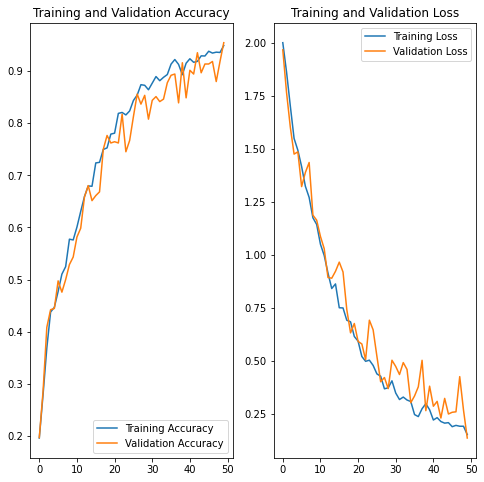

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: BA
predicted label: BA


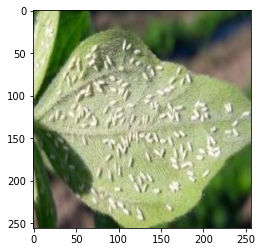

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## run inference on few sample images

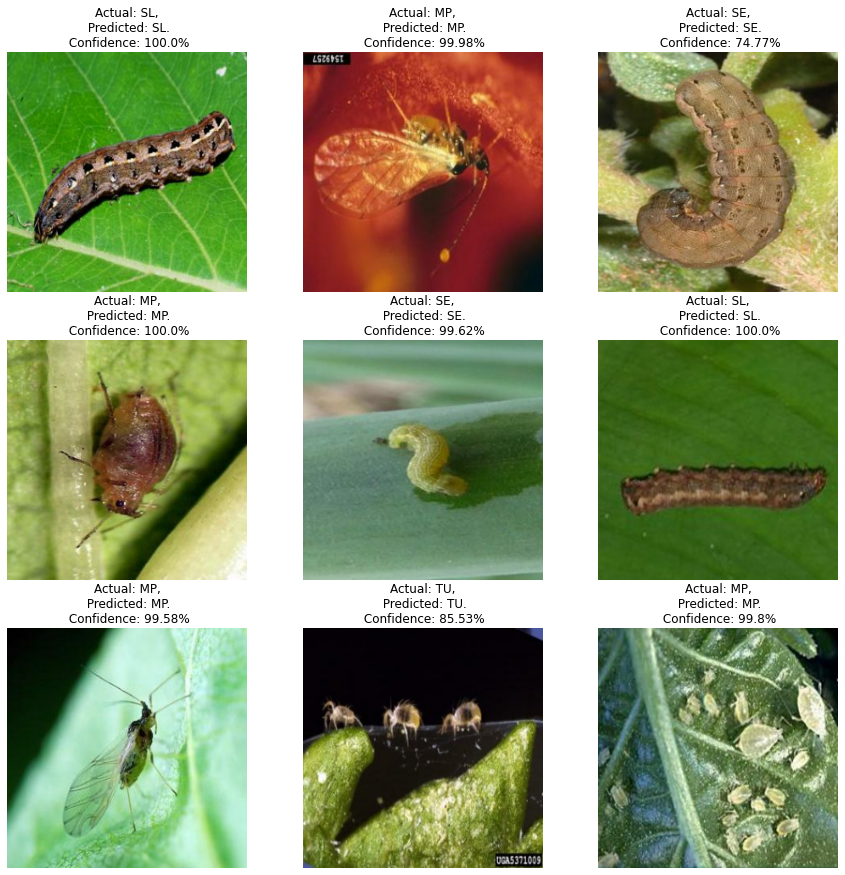

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [64]:
model.save("/content/drive/MyDrive/ML")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/assets


In [65]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [66]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)       

In [68]:
model.save("/content/saved_model/TOMATO.h5")

In [70]:
new_model = tf.keras.models.load_model('/content/saved_model/TOMATO.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)       

In [8]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [1]:
!jt -t chesterish

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.
